In [1]:
## This will install pandas profiling
## Uncomment if you do not have this package installed
## conda install -c conda-forge pandas-profiling

In [2]:
## pip install category_encoders

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pp
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures,LabelEncoder,OrdinalEncoder
from sklearn.linear_model import LinearRegression
from category_encoders.target_encoder import TargetEncoder
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from tqdm import tqdm


# Download Data and Preprocessing

In [4]:
data = pd.read_csv('vehicles.csv')

In [5]:
print(data.columns.values)

['id' 'url' 'region' 'region_url' 'price' 'year' 'manufacturer' 'model'
 'condition' 'cylinders' 'fuel' 'odometer' 'title_status' 'transmission'
 'vin' 'drive' 'size' 'type' 'paint_color' 'image_url' 'description'
 'county' 'state' 'lat' 'long']


# 1). Feature Identification

In [6]:
## This will take a long time
pp.ProfileReport(data)

D:\anaconda\install\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,25
Number of observations,509577
Total Missing (%),16.5%
Total size in memory,97.2 MiB
Average record size in memory,200.0 B
Numeric,6
Categorical,17
Boolean,0
Date,0
Text (Unique),1
Rejected,1


## By looking at the overview, I found these features that need to be dropped for different reasons

### ID: Too many distinct value and may leak information
### url: unrelevant features
### region_url: it contain information same as region
### Vin: Too many distinct values and missing values
### image_url: Unrelated feature
### description: Drop for now to have a simple model
### County: constant value, unrelevant feature

In [7]:
## Drop the feature mentioned
feature_to_drop = ["id", "url", "region_url", "vin","image_url", "description", "county"]

In [8]:
print("number of features to drop: ", len(feature_to_drop))
try:
    data = data.drop(columns = feature_to_drop)
except:
    print("feature are already dropped")

number of features to drop:  7


In [9]:
## remained features
print(data.iloc[0,:])
print("remained num of features(with target): ",len(data.iloc[0,:]))

region          salt lake city
price                    17899
year                      2012
manufacturer        volkswagen
model                   golf r
condition            excellent
cylinders          4 cylinders
fuel                       gas
odometer                 63500
title_status             clean
transmission            manual
drive                      4wd
size                   compact
type                 hatchback
paint_color              black
state                       ut
lat                    40.7372
long                  -111.858
Name: 0, dtype: object
remained num of features(with target):  18


In [10]:
## Assemble dataset
target = data['price'].to_frame()
train = data.drop(columns = 'price')

print(data.iloc[0,:])
print("remained num of features: ",len(data.iloc[0,:]))
print(target)

region          salt lake city
price                    17899
year                      2012
manufacturer        volkswagen
model                   golf r
condition            excellent
cylinders          4 cylinders
fuel                       gas
odometer                 63500
title_status             clean
transmission            manual
drive                      4wd
size                   compact
type                 hatchback
paint_color              black
state                       ut
lat                    40.7372
long                  -111.858
Name: 0, dtype: object
remained num of features:  18
        price
0       17899
1           0
2       46463
3           0
4       49999
...       ...
509572  15476
509573   9881
509574  24895
509575  32500
509576  12900

[509577 rows x 1 columns]


# 2). Preprocessing and Baseline Model


### Frist, subsample the dataset

In [11]:
sub_sample_rate = 0.05
sub_train,rest_train,sub_test,rest_test = train_test_split(train,target,train_size = sub_sample_rate,random_state =42)
print(len(sub_train.index))

25478


In [12]:
## handle missing value
## Here, I use most_frequent values

continuous = ["lat","long","odometer","year"]

cat = ['manufacturer', 'model', 'condition', 'cylinders','fuel', 'title_status',
       'transmission', 'drive', 'size','type', 'paint_color','region','state']

cont_imputer = make_pipeline(SimpleImputer(),StandardScaler())
cat_imputer = make_pipeline(SimpleImputer(strategy = "most_frequent"),OneHotEncoder(handle_unknown = "ignore"))

preprocess = make_column_transformer(
    (cont_imputer,continuous),
    (cat_imputer,cat),)

model = make_pipeline(preprocess,LinearRegression())
score = cross_val_score(model,sub_train,sub_test,cv = 10,scoring = "r2")
print(score.mean())

-1.2971431358255736


# 3). Feature Engineering

#### Price has two many zeros and large numbers, lets get rid of them

Note: I am modifying on the original dataset

number of features to drop:  7


{'whiskers': [<matplotlib.lines.Line2D at 0x2084c8767c8>,
 'caps': [<matplotlib.lines.Line2D at 0x208305f0248>,
 'boxes': [<matplotlib.lines.Line2D at 0x2078f600c08>],
 'medians': [<matplotlib.lines.Line2D at 0x20845e6c248>],
 'fliers': [<matplotlib.lines.Line2D at 0x20845e6c188>],
 'means': []}

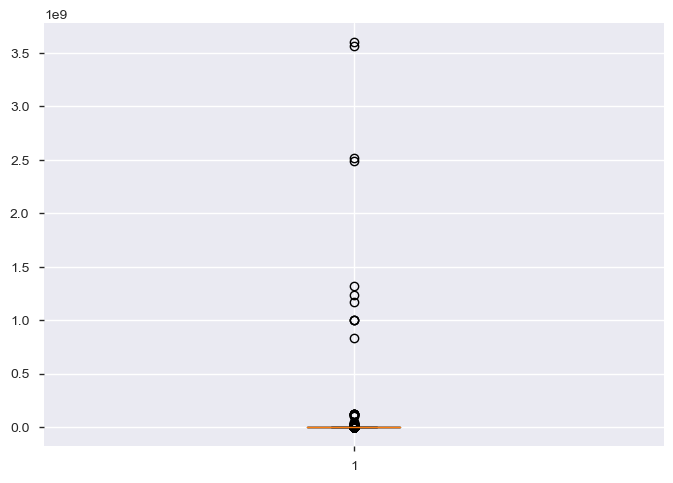

In [13]:
### Reload the data
data = pd.read_csv('vehicles.csv')
feature_to_drop = ["id", "url", "region_url", "vin","image_url", "description", "county"]
print("number of features to drop: ", len(feature_to_drop))
try:
    data = data.drop(columns = feature_to_drop)
except:
    print("feature are already dropped")

plt.boxplot(data["price"].values)

#### From the plot above, one can see that price have many outliers

In [14]:
### Drop outliers
price_threshold = 40000
data = data[(data["price"] !=  0) & (data["price"] <= price_threshold)]


453163


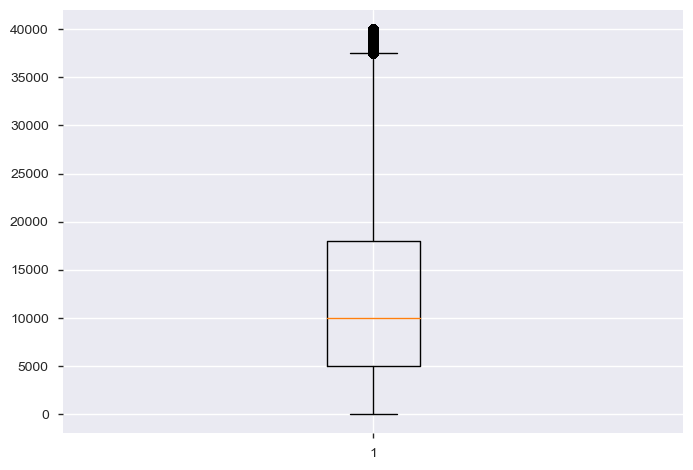

In [15]:
plt.boxplot(data["price"].values)
print(len(data.index))

In [16]:
## validation

target = data['price'].to_frame()
train = data.drop(columns = 'price')
sub_sample_rate = 0.01
sub_train,rest_train,sub_test,rest_test = train_test_split(train,target,train_size = sub_sample_rate,random_state =42)

continuous = ["lat","long","odometer","year"]

cat = ['manufacturer', 'model', 'condition', 'cylinders','fuel', 'title_status',
       'transmission', 'drive', 'size','type', 'paint_color','region','state']

cont_imputer = make_pipeline(SimpleImputer(),StandardScaler())
cat_imputer = make_pipeline(SimpleImputer(strategy = "most_frequent"),OneHotEncoder(handle_unknown = "ignore"))

preprocess = make_column_transformer(
    (cont_imputer,continuous),
    (cat_imputer,cat),)

model = make_pipeline(preprocess,LinearRegression())
score = cross_val_score(model,sub_train,sub_test,cv = 10,scoring = "r2")
print(score.mean())

-0.3278592454854955


### Then, lets deal with some of the cat variable that has too many distinct values by using target encoder

In [17]:
cat_target = ["region","model"]
cat_target_encoder = Pipeline([('target_encoder',TargetEncoder(smoothing = 0.1))])

### For a linear model, PolynomialFeatures should help with the lat and long feature because they are not linearly related with the target

In [18]:
polyfeatures = ["lat","long"]
polyfeature = Pipeline([('knn',KNNImputer(n_neighbors=5)),('scaler',StandardScaler()),('poly',PolynomialFeatures(2))])

In [19]:
target = data['price'].to_frame()
train = data.drop(columns = 'price')
sub_sample_rate = 0.05
sub_train,rest_train,sub_test,rest_test = train_test_split(train,target,train_size = sub_sample_rate,random_state =42)

In [20]:
continuous = ["odometer","year"]
cat = ['manufacturer','condition', 'cylinders','fuel', 'title_status','transmission', 'drive','paint_color',"state","type","size"]
ployfeatures = ["lat","long"]
cat_target = ["region","model"]

cont_imputer = make_pipeline(SimpleImputer(),StandardScaler())
cat_imputer = make_pipeline(SimpleImputer(strategy = "most_frequent"),OneHotEncoder(handle_unknown = "ignore"))

preprocess = make_column_transformer(
    (cont_imputer,continuous),
    (cat_imputer,cat),
    (polyfeature,polyfeatures),
    (cat_target_encoder,cat_target),
)

model = make_pipeline(preprocess,LinearRegression())
score = cross_val_score(model,sub_train,sub_test,cv = 10,scoring = "r2")
print(score.mean())

0.45850990691824667


# 4). Any model 

In [21]:
## reload data and do preprocessing again just to make sure all data are as expected.
data = pd.read_csv('vehicles.csv')
feature_to_drop = ["id", "url", "region_url","image_url", "description", "county","vin"]
data = data.drop(columns = feature_to_drop)
price_threshold = 50000
odometer_threshold = 300000
data = data[(data["price"] !=  0) & (data["price"] <= price_threshold)]
data = data[(data["odometer"] !=  0) & (data["odometer"] <= odometer_threshold)]
target = data['price'].to_frame()
train = data.drop(columns = 'price')

In [23]:
sub_sample_rate = 0.005 ## Strongly sub sample the data fro gridsearch
sub_train,rest_train,sub_test,rest_test = train_test_split(train,target,train_size = sub_sample_rate,random_state =23)
X_train, X_test, y_train, y_test = train_test_split(sub_train,sub_test,random_state= 22)
cont = ["odometer","year","lat","long"]
cat = ['manufacturer','condition', 'cylinders','fuel', 'title_status','transmission', 'drive','paint_color',"state","type","size","region","model"]

cont_imputer = make_pipeline(SimpleImputer())
cat_imputer = make_pipeline(SimpleImputer(strategy = "most_frequent"),OneHotEncoder(handle_unknown = "ignore"))

preprocess = make_column_transformer(
    (cont_imputer,cont),
    (cat_imputer,cat),
)

#### a). Tree

In [24]:
model = Pipeline([("pre",preprocess),("tree",DecisionTreeRegressor())])

param_grid = {'tree__max_leaf_nodes':  range(10,250,40),'tree__min_samples_split':  range(10,100,20)}
grid = GridSearchCV(model, param_grid=param_grid,
                    cv=5, return_train_score=True)
grid.fit(X_train, y_train.values.ravel())
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test.values.ravel())))

best mean cross-validation score: 0.520
best parameters: {'tree__max_leaf_nodes': 170, 'tree__min_samples_split': 70}
test-set score: 0.586


#### b). Random Forest

In [25]:
model = Pipeline([("pre",preprocess),("forest",RandomForestRegressor())])
param_grid = {'forest__n_estimators':  range(10,100,20),'forest__max_depth':  range(1,10,2)}
grid = GridSearchCV(model, param_grid=param_grid,
                    cv=5, return_train_score=True)
grid.fit(X_train, y_train.values.ravel())
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test.values.ravel())))

best mean cross-validation score: 0.620
best parameters: {'forest__max_depth': 9, 'forest__n_estimators': 70}
test-set score: 0.702


#### For forest, I tried different range of grid search and find the best parameters are not stable

#### c). Gradient boosting

In [26]:
model = make_pipeline(preprocess,GradientBoostingRegressor())
model = Pipeline([("pre",preprocess),("gdb",GradientBoostingRegressor())])
param_grid = {'gdb__n_estimators':  range(10,100,20),'gdb__max_depth' : range(1,10,2)}
grid = GridSearchCV(model, param_grid=param_grid,
                    cv=5, return_train_score=True)
grid.fit(X_train, y_train.values.ravel())
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test.values.ravel())))

best mean cross-validation score: 0.671
best parameters: {'gdb__max_depth': 5, 'gdb__n_estimators': 90}
test-set score: 0.735


# 5). Feature Selections

In [27]:
## Here I am using Gradient Boosting because it has better performance and much faster than random forest.

In [28]:
sub_sample_rate = 0.1
sub_train,rest_train,sub_test,rest_test = train_test_split(train,target,train_size = sub_sample_rate,random_state =23)
X_train, X_test, y_train, y_test = train_test_split(sub_train,sub_test,random_state= 22)
cont = ["odometer","year","lat","long"]
cat = ['manufacturer','condition', 'cylinders','fuel', 'title_status','transmission', 'drive','paint_color',"state","type","size","region","model"]

cont_imputer = make_pipeline(SimpleImputer())
cat_imputer = Pipeline([("imputer",SimpleImputer(strategy = "most_frequent")),('onehot',OneHotEncoder(handle_unknown = "ignore"))])

preprocess = make_column_transformer(
    (cont_imputer,cont),
    (cat_imputer,cat),
)

In [29]:
## I did some extra gridsearch to get better performance

model = Pipeline([("pre",preprocess),("gdb",GradientBoostingRegressor(n_estimators = 800,max_depth = 5,subsample= 0.9,learning_rate=0.08,warm_start = True))])
# param_grid = {'gdb__learning_rate' : np.arange(0.01,0.1,0.01)}
# grid = GridSearchCV(model, param_grid=param_grid,
#                     cv=5, return_train_score=True)
# grid.fit(X_train, y_train.values.ravel())
# print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
# print("best parameters: {}".format(grid.best_params_))

# print("test-set score: {:.3f}".format(grid.score(X_test, y_test.values.ravel())))

model.fit(X_train, y_train.values.ravel())
model.score(X_test, y_test.values.ravel())

0.808986949598952

In [30]:
cat_imputer.fit(X_train[cat])
coef = np.absolute(model["gdb"].feature_importances_)
feature_name = np.concatenate((cont,cat_imputer["onehot"].get_feature_names()))
print(coef)
arg = np.argsort(coef)[::-1]

[0.11205767 0.39651706 0.02025171 ... 0.         0.         0.        ]


Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state', 'lat', 'long'],
      dtype='object')


Text(0.5, 1.0, '20 most important coefficients ')

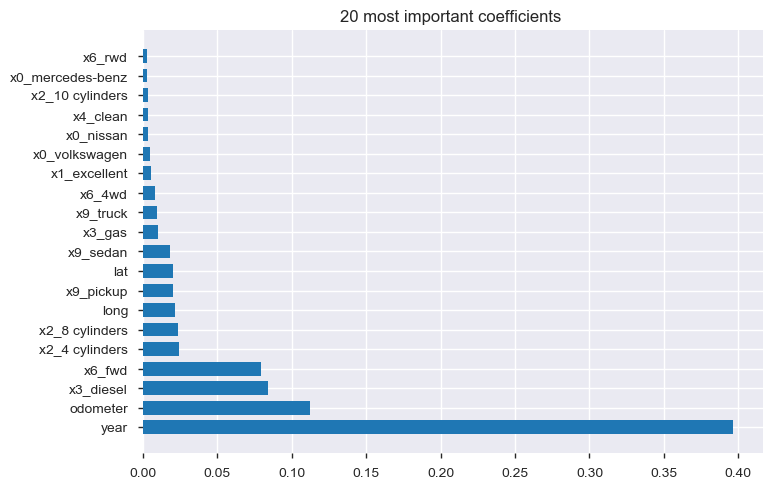

In [31]:
fea_name_ordered =[]
coef_value =[]
print(data.columns)
for i in range(20):
    fea_name_ordered.append(feature_name[arg[i]]) 
    coef_value.append(coef[arg[i]])
plt.barh(fea_name_ordered, coef_value, height =0.7)
plt.title('20 most important coefficients ')

## It looks like 'model', 'condition', 'cylinders', 'fuel','manufacturer','title_status','drive', 'type' are the most important features
## Try drop other features and see the change of the accruacy

In [32]:
## reload data and do preprocessing again just to make sure all data are as expected.
data = pd.read_csv('vehicles.csv')
feature_to_drop = ["id", "url","vin","region_url","image_url", "description", "county"]
data = data.drop(columns = feature_to_drop)
extra_feature_to_drop = ["size", 'transmission','paint_color',"state",'region']
data = data.drop(columns = extra_feature_to_drop)
price_threshold = 50000
odometer_threshold = 300000
data = data[(data["price"] !=  0) & (data["price"] <= price_threshold)]
data = data[(data["odometer"] !=  0) & (data["odometer"] <= odometer_threshold)]
target = data['price'].to_frame()
train = data.drop(columns = 'price')
print(train.columns)

Index(['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'drive', 'type', 'lat', 'long'],
      dtype='object')


In [33]:
sub_sample_rate = 0.1 
sub_train,rest_train,sub_test,rest_test = train_test_split(train,target,train_size = sub_sample_rate,random_state =23)
X_train, X_test, y_train, y_test = train_test_split(sub_train,sub_test,random_state= 22)
cont = ["odometer","year","lat","long"]
cat = ['model', 'condition', 'cylinders', 'fuel','manufacturer','title_status','drive', 'type']

cont_imputer = make_pipeline(SimpleImputer())
cat_imputer = Pipeline([("imputer",SimpleImputer(strategy = "most_frequent")),('onehot',OneHotEncoder(handle_unknown = "ignore"))])

preprocess = make_column_transformer(
    (cont_imputer,cont),
    (cat_imputer,cat),
)

In [34]:
model = Pipeline([("pre",preprocess),("gdb",GradientBoostingRegressor(n_estimators = 800
                                                                      ,max_depth = 5,subsample= 0.9,learning_rate=0.08,warm_start = True))])
model.fit(X_train, y_train.values.ravel())
model.score(X_test, y_test.values.ravel())

0.8084783197098317

## Deleting non-important features gives same accuracy

In [35]:
## Training on the entire dataset

X_train, X_test, y_train, y_test = train_test_split(train,target,random_state= 22)
cont = ["odometer","year","lat","long"]
cat = ['model', 'condition', 'cylinders', 'fuel','manufacturer','title_status','drive', 'type']

cont_imputer = make_pipeline(SimpleImputer())
cat_imputer = Pipeline([("imputer",SimpleImputer(strategy = "most_frequent")),('onehot',OneHotEncoder(handle_unknown = "ignore"))])

preprocess = make_column_transformer(
    (cont_imputer,cont),
    (cat_imputer,cat),
)

In [36]:
model = Pipeline([("pre",preprocess),("gdb",GradientBoostingRegressor(n_estimators = 800
                                                                      ,max_depth = 5,subsample= 0.9,learning_rate=0.08,warm_start = True))])
model.fit(X_train, y_train.values.ravel())
model.score(X_test, y_test.values.ravel())

0.8290698233035165

# 6). An explainable model 

In [2]:
## reload data and do preprocessing again just to make sure all data are as expected.
data = pd.read_csv('vehicles.csv')
feature_to_drop = ["id", "url","vin","region_url","image_url", "description", "county"]
data = data.drop(columns = feature_to_drop)
extra_feature_to_drop = ["size", 'transmission','paint_color','manufacturer','title_status',"state",'region']
data = data.drop(columns = extra_feature_to_drop)
price_threshold = 50000
odometer_threshold = 300000
data = data[(data["price"] !=  0) & (data["price"] <= price_threshold)]
data = data[(data["odometer"] !=  0) & (data["odometer"] <= odometer_threshold)]
target = data['price'].to_frame()
train = data.drop(columns = 'price')
print(train.columns)

Index(['year', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'drive',
       'type', 'lat', 'long'],
      dtype='object')


In [3]:
sub_sample_rate = 0.1
sub_train,rest_train,sub_test,rest_test = train_test_split(train,target,train_size = sub_sample_rate,random_state =23)
X_train, X_test, y_train, y_test = train_test_split(sub_train,sub_test,random_state= 22)
cont = ["odometer","year","lat","long"]
cat = ['model', 'condition', 'cylinders', 'fuel','drive', 'type']

cont_imputer = make_pipeline(SimpleImputer())
cat_imputer = Pipeline([("imputer",SimpleImputer(strategy = "most_frequent")),('onehot',OneHotEncoder(handle_unknown = "ignore"))])

preprocess = make_column_transformer(
    (cont_imputer,cont),
    (cat_imputer,cat),
)

In [4]:
model = Pipeline([("pre",preprocess),("tree",DecisionTreeRegressor(max_leaf_nodes = 20))])
model.fit(X_train, y_train.values.ravel())
model.score(X_test, y_test.values.ravel())

0.5922432408033871

In [5]:
cat_imputer.fit(X_train[cat])
feature_name = np.concatenate((cont,cat_imputer["onehot"].get_feature_names()))

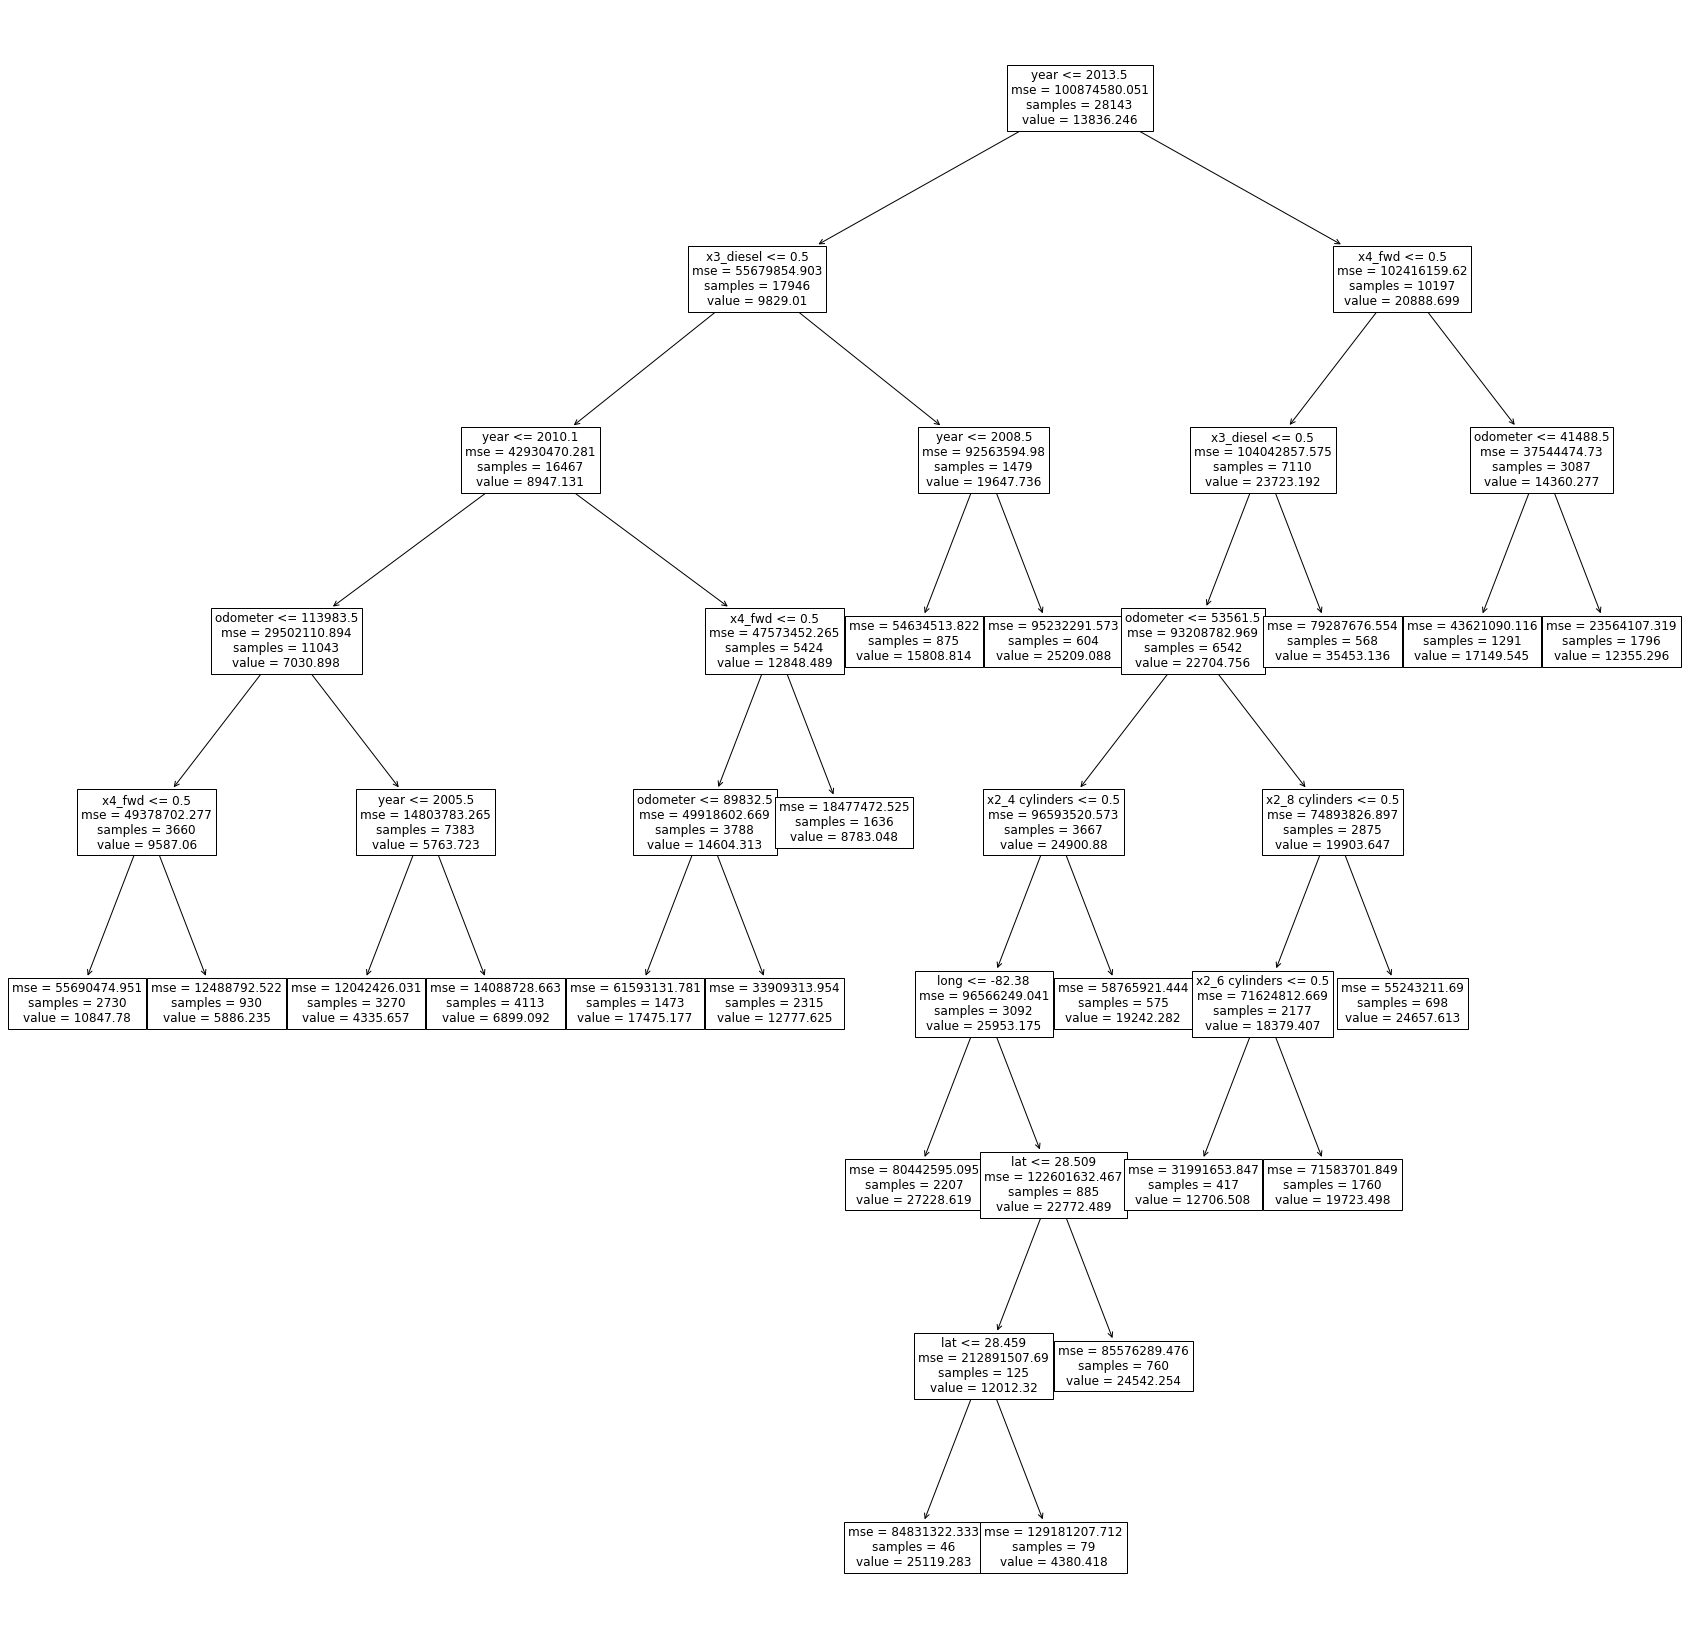

In [11]:
plt.figure(figsize=(30,30))
tree_dot = plot_tree(model["tree"],feature_names=feature_name,fontsize = 12)

### I am able to get some insight from this model. First, the car producted after mid of 2013 has higher price, and then, all-wheel drive cars will have higher price than front-whell drive, and diesel car is more expensice than non-diesel.